In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from tqdm import tqdm

In [8]:
def get_FPU_func(alpha, beta):
    def FPU(r):
        try:
            return r**2/2 + alpha*r**3/3+beta*r**4/4
        except:
            print('ERROR', r)
    return FPU

def get_FPU_der(alpha, beta):
    def FPU_der(r):
        try:
            return r + alpha*r**2+beta*r**3
        except:
            print('ERROR', r)
    return FPU_der

In [9]:
m = 1
a = 1

In [10]:
alpha = 1
beta = 1

In [11]:
dt = 0.1
k = 100000 # время 134041
t_end = k*dt
n = 25 # точки

In [12]:
I = 11
q = 0.01*I

In [13]:
FPU = get_FPU_func(alpha, beta)
FPU_der = get_FPU_der(alpha, beta)

### Расчёт с помощью обычного Алгоритма Верле

Для проверки формул и алгоритма

In [14]:
q_init = np.zeros(2*n+2)
v_init = np.zeros(2*n+2)
a_init = np.zeros(2*n+2)

In [15]:
q_init[n] -= q
q_init[n+1] += q

In [16]:
a_init[1:-1] = -(-FPU_der(q_init[:-2]-q_init[1:-1])+FPU_der(q_init[1:-1]-q_init[2:]))/m
a_init[[0,-1]] = a_init[[-2,1]]

In [17]:
q_cur = q_init
v_cur = v_init
a_cur = a_init

In [18]:
for i in tqdm(range(k)):
    q_cur = q_cur + v_cur*dt+0.5*a_cur*dt**2
    v_half = v_cur + 0.5 * a_cur*dt
    a_cur[1:-1] = -(-FPU_der(q_cur[:-2]-q_cur[1:-1])
                         +FPU_der(q_cur[1:-1]-q_cur[2:]))/m
    a_cur[[0,-1]] = a_cur[[-2,1]]
    v_cur = v_half + 0.5*a_cur*dt
    assert not np.any(np.isnan(q_cur)), 'q_nan'
    assert not np.any(np.isnan(v_cur)), 'v_nan'
    assert not np.any(np.isnan(a_cur)), 'a_nan'
    assert not np.any(np.isinf(q_cur)), 'q_inf'
    assert not np.any(np.isinf(v_cur)), 'v_inf'
    assert not np.any(np.isinf(a_cur)), 'a_inf'
    assert q_cur[0] == q_cur[-2], f'q0[{i}]:{(q_cur[0],  q_cur[-2])}'
    assert q_cur[1] == q_cur[-1], f'q1[{i}]:{(q_cur[1],  q_cur[-1])}'
    assert v_cur[0] == v_cur[-2], f'v0[{i}]:{(v_cur[0],  v_cur[-2])}'
    assert v_cur[1] == v_cur[-1], f'v1[{i}]:{(v_cur[1],  v_cur[-1])}'

  3%|▎         | 3027/100000 [00:00<00:14, 6717.47it/s]

100%|██████████| 100000/100000 [00:11<00:00, 9015.59it/s]


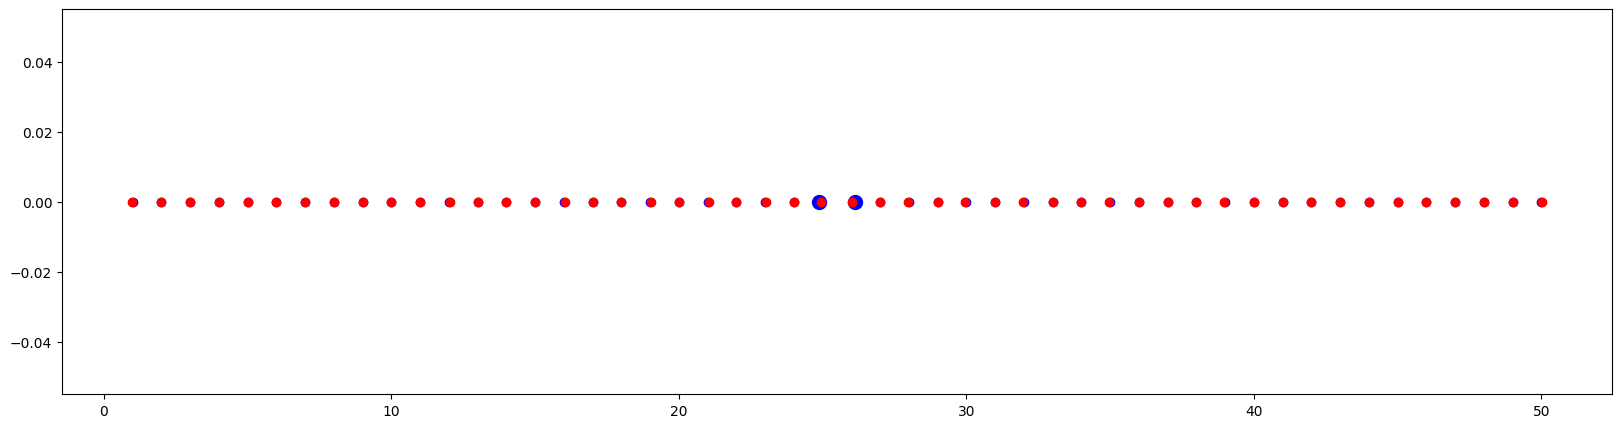

In [19]:
plt.figure(figsize=(20,5))
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, np.zeros(2*n), c='b')
plt.scatter(q_init[[n,n+1]]+[n*a, (n+1)*a], np.zeros(2), s=100, c='b')
plt.scatter(q_cur[1:-1]+np.arange(1,2*n+1)*a, np.zeros(2*n), c='r')
# plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_cur[1:-1], c='r')
plt.show()

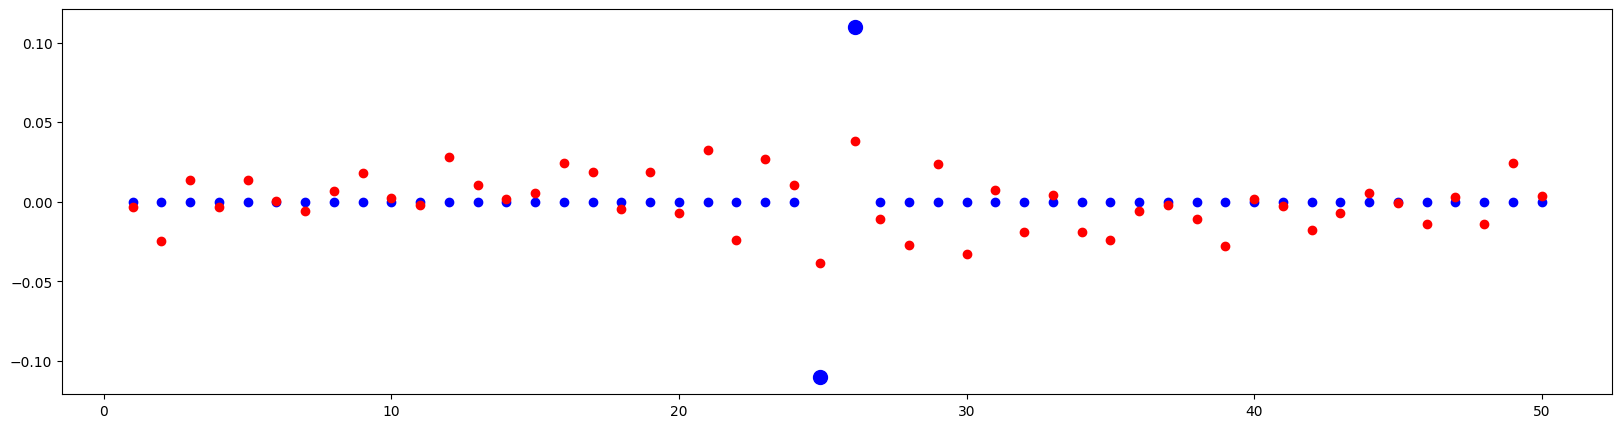

In [20]:
plt.figure(figsize=(20,5))
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_init[1:-1], c='b')
plt.scatter(q_init[[n,n+1]]+[n*a, (n+1)*a], q_init[[n,n+1]], s=100, c='b')
plt.scatter(q_init[1:-1]+np.arange(1,2*n+1)*a, q_cur[1:-1], c='r')
plt.show()

In [21]:
q_cur

array([ 0.00353806, -0.00353806, -0.02467136,  0.01380955, -0.00322349,
        0.01376271,  0.00067532, -0.0056477 ,  0.00678206,  0.01796644,
        0.0023879 , -0.00173471,  0.02807479,  0.010529  ,  0.00190061,
        0.00573009,  0.02421427,  0.01873379, -0.00457243,  0.01873931,
       -0.00722072,  0.03278596, -0.02371337,  0.02717015,  0.01083128,
       -0.03825363,  0.03825363, -0.01083128, -0.02717015,  0.02371337,
       -0.03278596,  0.00722072, -0.01873931,  0.00457243, -0.01873379,
       -0.02421427, -0.00573009, -0.00190061, -0.010529  , -0.02807479,
        0.00173471, -0.0023879 , -0.01796644, -0.00678206,  0.0056477 ,
       -0.00067532, -0.01376271,  0.00322349, -0.01380955,  0.02467136,
        0.00353806, -0.00353806])

### Графики по посчитанным данным

Рассчёт был сделан с помощью программы на C++.

In [22]:
import pandas as pd

In [81]:
df_com = pd.read_csv('results\COM_10000101_res.out', index_col=False)

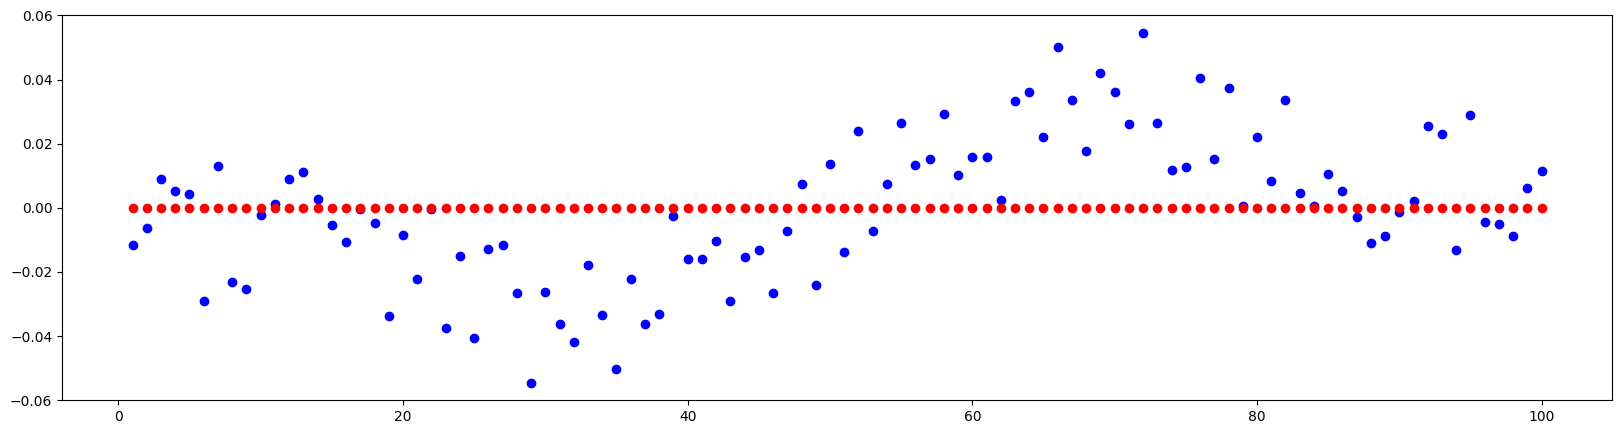

In [82]:
plt.figure(figsize=(20,5))
plt.scatter(df_com.x.values, df_com.q.values, c='b')
# plt.scatter(df.x.values, df.q.values, s=100, c='b')
plt.scatter(df_com.x.values, df_com.q.values*0, c='r')
plt.show()

In [83]:
energy_calc_com = np.sum(FPU(df_com.q.values[:-1] - df_com.q.values[1:])) + FPU(df_com.q.values[-1] - df_com.q.values[0])
energy_calc_com += np.sum(df_com.v.values**2) * 0.5

In [85]:
df_smp = pd.read_csv('results\SMP_10000101_res.out', index_col=False)

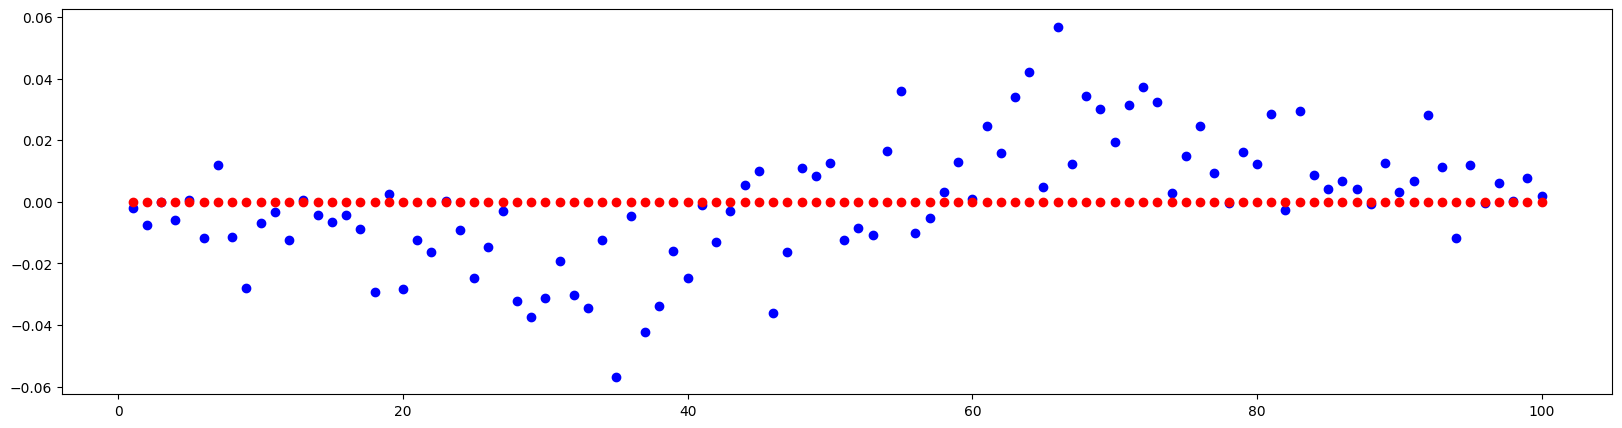

In [77]:
plt.figure(figsize=(20,5))
plt.scatter(df_smp.x.values, df_smp.q.values, c='b')
# plt.scatter(df.x.values, df.q.values, s=100, c='b')
plt.scatter(df_smp.x.values, df_smp.q.values*0, c='r')
plt.show()

In [86]:
energy_calc_smp = np.sum(FPU(df_smp.q.values[:-1] - df_smp.q.values[1:])) + FPU(df_smp.q.values[-1] - df_smp.q.values[0])
energy_calc_smp += np.sum(df_smp.v.values**2) * 0.5

In [88]:
energy_0 = np.sum(FPU(np.array([0,q,-q]) - np.array([q,-q,0])))

In [89]:
energy_0, energy_calc_smp, energy_calc_com

(0.039620845, 0.03971258528216125, 0.03940706813437151)